# Data Loading and Transformation from Matrices to Link Counts

make sure to upload data (ie "od-demand-202010-150.npy", od_stop, od_time,etc) from local machine to google colab notebook instance by clicking on "upload files", on the left. They must be re-uploaded every time the notebook instance is closed and re-opened. However, it doesn't take a long time to transform all the data.   

In [26]:
import tensorflow as tf
import pandas as pd
import numpy as np
import pickle

def load_data(fp = '', pickle = False):
    data = np.load(fp, allow_pickle = pickle )
    return data

# def load_stop_data(fp=''):
#     data = pickle.load(fp)
#     return data

def transform_matrix(matrix):
    """
    Assuming matrix is 10x10
    """
    link_counts = []
    for i in range(len(matrix)-1):
        sum = np.sum(matrix[0:i+1, i+1:])
        link_counts.append(sum)

    return link_counts

def transform_all(matrices):
    all_counts = []
    for i in range(len(matrices)):
        count = transform_matrix(matrices[i])
        all_counts.append(count)
    return all_counts
    
demand_matrices = load_data('od-demand-202010-150.npy')

stop_names = load_data('od_stop-202010-150.npy', pickle = True)
print("bus stops: ", stop_names[0:10])

dates = load_data('od_time-202010-150.npy')
dates.shape = [np.shape(dates)[0], 1]
print("dimensions of date data: ", np.shape(dates))

# Finally we transform the data from matrices to link counts
route_counts = transform_all(demand_matrices)
print("dimension of transformed matrices: ", np.shape(route_counts))

bus stops:  ['KDST' 'EGEV' 'HHLS' 'HHM' 'GLHO' 'NÆST' 'KLBV' 'RYST' 'HKP' 'NPST1']
dimensions of date data:  (5786, 1)
dimension of transformed matrices:  (5786, 9)


#Basic Plotting and Data Visualization

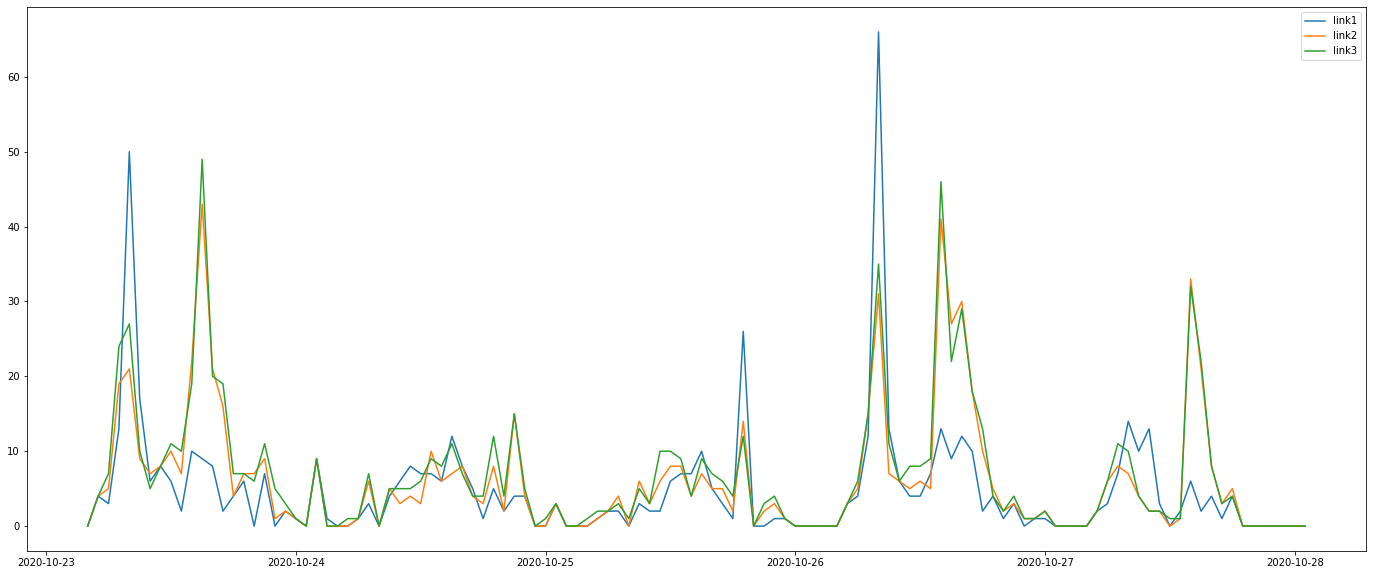

[0, 1, 2]


In [27]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

def date_to_string(dates):
    date = ""
    new_dates = []
    for d in dates:
        date = str(d)[2:15]
        new_dates.append(date)
    return new_dates


def transform_to_plot_data(route_counts, start, stop):
    """ Transforms the route counts to a format that can be easily 
        plotted and visualized.
        We create a time series of data (in 1 hour intervals) for each link.
    """
    if not stop <= np.shape(route_counts)[0]:
        print("Error- interval end longer than route count matrix")
        return -1

    link_dict = {}
    for i in range(np.shape(route_counts)[1]):
        links = []
        link_num = i+1

        for j in range(start, stop):
            links.append(route_counts[j][i])

        link_dict[link_num] = links

    return link_dict


def plot_route_counts(route_counts, start, stop, links = range(len(route_counts[1])), plot_type = 'line'):
    """
    Plot the counts at each link over a given time interval.
    When entering in the links you wish to plot, subtract 1. 
    i.e. links = [0,1,2] if you wish to plot links 1, 2, 3.
    It's just an indexing thing. 
    """


    link_dict = transform_to_plot_data(route_counts, start, stop)
    fig = plt.figure(figsize=(24,10))
    
    if plot_type == 'line':
        for i in links:
            plt.plot(dates[start:stop], link_dict[i+1], label='link'+str(i+1))
    elif plot_type == 'bar':

        for i in links:
            plt.bar(list(np.arange(start, stop)), list(link_dict[i+1]))
            plt.xticks(np.arange(start, stop), date_to_string(dates[start:stop]), rotation = 90)

    plt.legend()
    plt.show()
    


links = [0,1,2]
plot_route_counts(route_counts, 5668, 5786, links)
print(links)



#Data Normalization

In [28]:
from sklearn.preprocessing import MinMaxScaler

X = np.array(route_counts) 
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(X)
X = scaler.transform(X)

#Sequence creation of 1 hour of output using slide window method

In [29]:
look_back = 21
len_sequence = look_back
batch_size = 100
len_data = X.shape[0]

data = []
# create all possible sequences of length seq_len
for index in range(len_data - look_back - 1): 
    data.append(X[index: index + look_back])
data = np.array(data)

X_model1 = data[:len_data,:-1,:]
Y_model1 = data[:len_data,-1,:]

num_features = X_model1.shape[2]

#Split up Sequences into Train, Validation, Test sets

In [30]:
class Dataset():
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        # Return the size of the dataset
        return len(self.targets)

    def __getitem__(self, index):
        # Retrieve inputs and targets at the given index
        X = self.inputs[index]
        y = self.targets[index]

        return X, y

    
def create_datasets(X, Y, dataset_class, p_train=0.8, p_val=0.1, p_test=0.1):
    # Define partition sizes
    num_train = int(len_data*p_train)
    num_val = int(len_data*p_val)
    num_test = int(len_data*p_test)

    # Get inputs and targets for each partition
    inputs_train, targets_train = X[:num_train], Y[:num_train]  
    inputs_val, targets_val = X[num_train:num_train+num_val], Y[num_train:num_train+num_val]
    inputs_test, targets_test = X[-num_test:], Y[-num_test:]

    # Create datasets
    training_set = dataset_class(inputs_train, targets_train)
    validation_set = dataset_class(inputs_val, targets_val)
    test_set = dataset_class(inputs_test, targets_test)

    return training_set, validation_set, test_set


training_set, validation_set, test_set = create_datasets(X_model1, Y_model1, Dataset)

print(f'We have {len(training_set)} samples in the training set.')
print(f'We have {len(validation_set)} samples in the validation set.')
print(f'We have {len(test_set)} samples in the test set.')

We have 4628 samples in the training set.
We have 578 samples in the validation set.
We have 578 samples in the test set.


#Create Data Loader to simplify data loading process during training

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
def load_dataset():

    trainloader = torch.utils.data.DataLoader(
      dataset = training_set,
      batch_size= batch_size,
      num_workers = 0,
      shuffle= True
    )

    validationloader = torch.utils.data.DataLoader(
      dataset = validation_set,
      batch_size= batch_size,
      num_workers= 0,
      shuffle= True
    )

    testloader = torch.utils.data.DataLoader(
      dataset = test_set,
      batch_size= batch_size,
      num_workers= 0,
      shuffle= False
    )

    return trainloader, validationloader, testloader

trainloader, validationloader, testloader = load_dataset()

#Define LSTM Model

In [32]:


class MyRecurrentNet(nn.Module):
    def __init__(self):
        super(MyRecurrentNet, self).__init__()
        
        # Recurrent layer
        self.lstm = nn.LSTM(input_size=num_features,
                         hidden_size=30,
                         num_layers=2,
                         bidirectional=False,
                         batch_first = True,
                         dropout = 0.6)
        
        # Output layer
        self.l_out = nn.Linear(in_features=30,
                            out_features=num_features,
                            bias=False)
        
    def forward(self, x):
        batch_size = x.shape[0]
        x, (h, c) = self.lstm(x)
        
        # Flatten output for feed-forward layer
        x = x.contiguous().view(-1, self.lstm.hidden_size)
        
        # Output layer
        x = self.l_out(x)
        x = torch.Tensor.reshape(x, (batch_size, len_sequence - 1, num_features))

        # take the last output of the sequence
        x = x[:, -1, :]
        return x

net = MyRecurrentNet()
net = net.float()
print(net)

MyRecurrentNet(
  (lstm): LSTM(9, 30, num_layers=2, batch_first=True, dropout=0.6)
  (l_out): Linear(in_features=30, out_features=9, bias=False)
)


#Define Loss Function/ Criterion and Optimizer Settings

In [33]:
num_epochs = 200

# Initialize a new network
net = MyRecurrentNet()

# Define a loss function and optimizer for this problem
criterion = nn.MSELoss()
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum = 0.9)
optimizer = optim.Adam(net.parameters(), lr=0.003)

#Implement Training Loop

In [34]:
# Track loss
training_loss, validation_loss = [], []

# For each epoch
for i in range(num_epochs):
    
    # Track loss
    epoch_training_loss = 0
    epoch_validation_loss = 0
    
    net.eval()
        
    # For each sentence in validation set
    for _,(inputs, targets) in enumerate(validationloader):
        batch = inputs.shape[0]

        inputs= inputs.float()
        targets = targets.float()
        # Forward pass
        outputs = net(inputs)
        # Compute loss
        loss = criterion(outputs, targets)
        # Update loss
        epoch_validation_loss += loss.detach().numpy() * batch
    
    net.train()
    
    # For each sentence in training set
    for _,(inputs, targets) in enumerate(trainloader):
        batch = inputs.shape[0]
        inputs = inputs.float()
        targets = targets.float()

        # Forward pass
        outputs = net(inputs)
        # Compute loss
        loss = criterion(outputs, targets)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Update loss
        epoch_training_loss += loss.detach().numpy() * batch
        
    # Save loss for plot
    training_loss.append(epoch_training_loss/len(training_set))
    validation_loss.append(epoch_validation_loss/len(validation_set))

    # Print loss every 10 epochs
    if i % 10 == 0:
        print(f'Epoch {i}, training loss: {training_loss[-1]}, validation loss: {validation_loss[-1]}')

Epoch 0, training loss: 0.012319204046140612, validation loss: 0.03874038424097955
Epoch 10, training loss: 0.0034347383701665104, validation loss: 0.004058187901587016
Epoch 20, training loss: 0.0029929338507845276, validation loss: 0.003727643820698853
Epoch 30, training loss: 0.0027984855760954637, validation loss: 0.0033103271998194367
Epoch 40, training loss: 0.0025519054358287383, validation loss: 0.003285033737106255
Epoch 50, training loss: 0.0025173476319631295, validation loss: 0.0031633457228554263
Epoch 60, training loss: 0.0025657384012211615, validation loss: 0.003251635359123246
Epoch 70, training loss: 0.0024220080101015748, validation loss: 0.003209587032697244
Epoch 80, training loss: 0.002465107534648231, validation loss: 0.00301580540561939
Epoch 90, training loss: 0.002380794841899193, validation loss: 0.0032680681391029417
Epoch 100, training loss: 0.002315543721170006, validation loss: 0.003014063367549214
Epoch 110, training loss: 0.002280850479296387, validatio

#Implement Test Loop for 1 hour

In [35]:
targets_test = []
outputs_test = []
targets_test_normalized = []
outputs_test_normalized = []

def series_criterion_error(forecast, actual):
    # find criterion error just like in training, for the test series 
 
    if len(forecast) and len(actual) <= 0:
        raise ValueError("forecast and actual series must be longer than 0")
 
    forecast = torch.tensor(forecast)
    actual = torch.tensor(actual)
    mse = 0
    for i in range(forecast.shape[0]):
        loss = criterion(forecast[i], actual[i])
        mse += loss.item()
 
    mse = mse/forecast.shape[0]    
    return mse

# Get first sentence in test set
net.eval()
for _,(inputs, targets) in enumerate(testloader):
  inputs = inputs.float()
  targets = targets.float()
  targets_test_normalized += targets.tolist()
  targets = np.round(scaler.inverse_transform(targets))
  targets_test = targets_test + targets.tolist()
  # Forward pass
  output = net.forward(inputs).data.numpy()
  outputs_test_normalized += output.tolist()
  #inverse transform the data
  output = np.round(scaler.inverse_transform(output))
  outputs_test = outputs_test + output.tolist()

print("Test Error: " + str(series_criterion_error(outputs_test_normalized, targets_test_normalized)))

Test Error: 0.003504517950505442


#Plots for test predictions of 1 hour

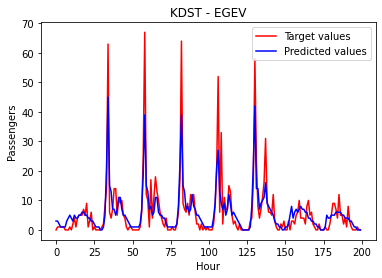

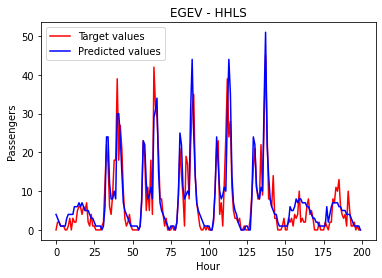

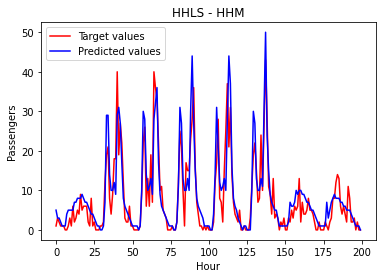

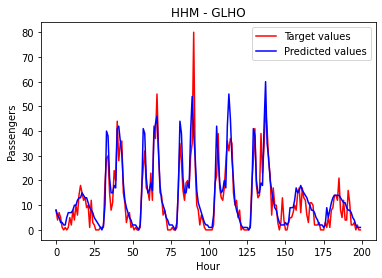

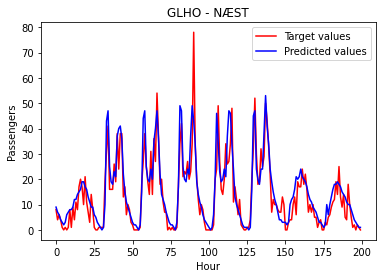

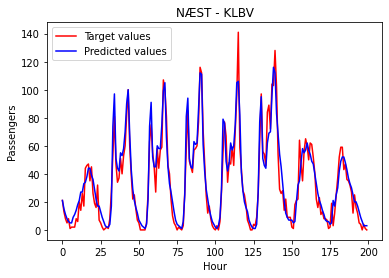

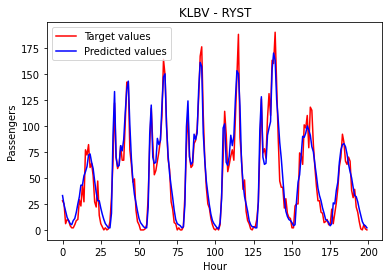

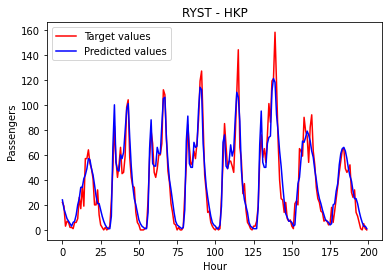

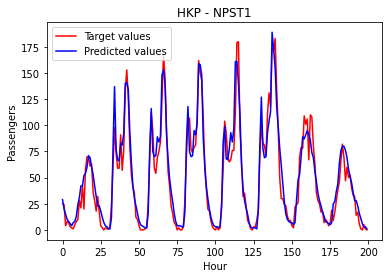

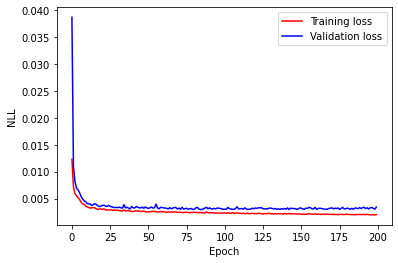

In [36]:
# Reduce the size to show better in plot
MAX_HOURS = 200
targets_test = targets_test[:MAX_HOURS]
outputs_test = outputs_test[:MAX_HOURS]

for i in range(0,num_features):
  hour = np.arange(len(targets_test))
  title = stop_names[i] + " - " +stop_names[i+1]
  plt.figure()
  plt.plot(hour, [link[i] for link in targets_test], 'r', label='Target values',)
  plt.plot(hour, [link[i] for link in outputs_test], 'b', label='Predicted values')
  plt.legend()
  plt.xlabel('Hour'), plt.ylabel('Passengers')
  plt.title(title)
  plt.show()

# Plot training and validation loss
epoch = np.arange(len(training_loss))

plt.figure()
plt.plot(epoch, training_loss, 'r', label='Training loss',)
plt.plot(epoch, validation_loss, 'b', label='Validation loss')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('NLL')
plt.show()

#Implement test loop for prediction of 8 hours using the 1 hour model

In [37]:
def extrapolate(X, Y, start, num_steps):
    """
    Based on a single input sequence of length 19, it predicts the next output value y.
    This output is then used as part of the input for the next prediction sequence. 

    """
    
    start_seq = X[start]
    targets = []
    
    outputs_test = []
    # convert input to float tensor and reshape
    start_seq = torch.tensor(start_seq)
    start_seq = start_seq.float()
    start_seq = torch.Tensor.reshape(start_seq, (1, start_seq.shape[0], start_seq.shape[1]))
    net.eval()
    for i in range(1, num_steps+1):
        # refresh buffer with new actual data every 8 steps
        if not i%8:
            new_input = X[start+i-20]
            start_seq = torch.tensor(new_input)
            start_seq = start_seq.float()
            start_seq = torch.Tensor.reshape(start_seq, (1, start_seq.shape[0], start_seq.shape[1]))
        
        targets.append(Y[start + i - 20].tolist())
        # Forward pass
        output = net.forward(start_seq).data.numpy()
        
        output = torch.from_numpy(output)        
 
        #reshape the output
        output = torch.Tensor.reshape(output, (1, output.shape[0], output.shape[1]))
        
        # append output to last step of input, remove the first step of input
        new_input = start_seq[0,1:,:]
  
        #reshape the input
        new_input = torch.Tensor.reshape(new_input, (1, new_input.shape[0], new_input.shape[1]))
  
        new_input = torch.cat((new_input, output),dim=1)
        
        start_seq = new_input
 
        outputs_test = outputs_test + output.tolist()
    
    reformatted_outputs = []
    for row in outputs_test:
        reformatted_outputs.append(row[0])
    return reformatted_outputs,targets

start = len(training_set) + len(validation_set)
num_steps = 200
pred, targets = extrapolate(X_model1, Y_model1, start, num_steps)
print("Test Error: " + str(series_criterion_error(pred, targets)))
pred = np.round(scaler.inverse_transform(pred))





Test Error: 0.0037828418845583657


#Plots for test predictions of 8 hours

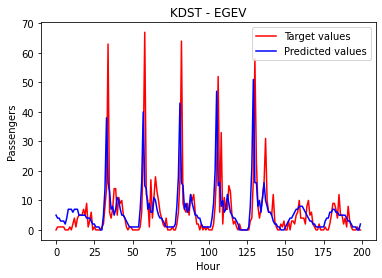

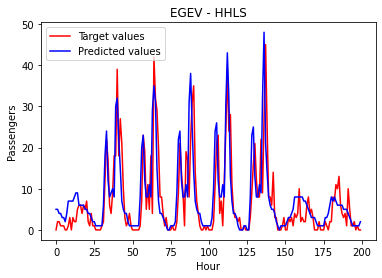

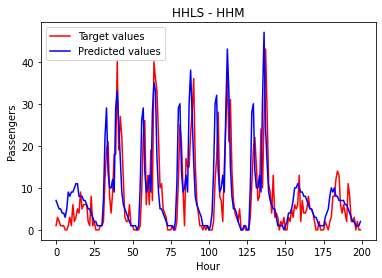

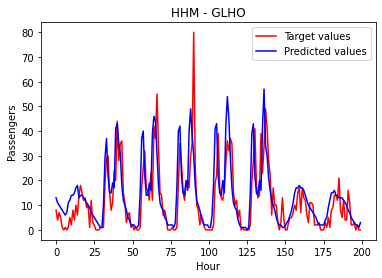

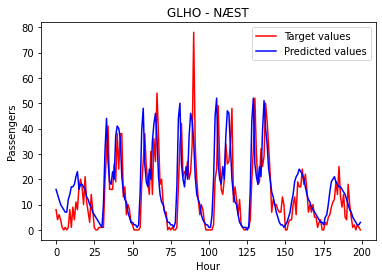

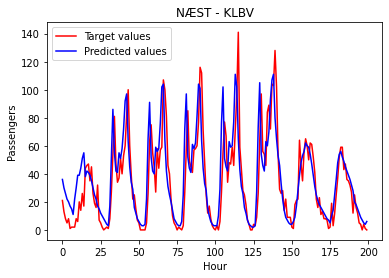

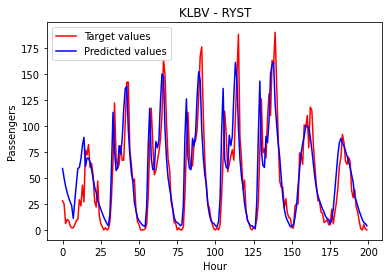

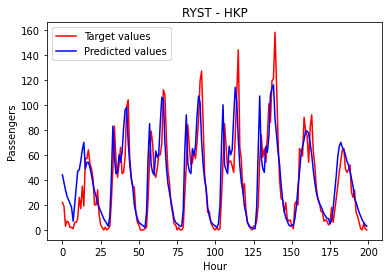

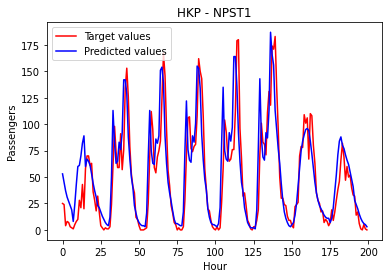

In [38]:
def plot_extrapolation(pred, actual):
    for i in range(0,len(pred[0])):
        hour = np.arange(len(pred))
        title = stop_names[i] + " - " +stop_names[i+1]
        plt.figure()
        plt.plot(hour, [row[i] for row in actual], 'r', label='Target values',)
        plt.plot(hour, [row[i] for row in pred], 'b', label='Predicted values')
        plt.legend()
        plt.xlabel('Hour'), plt.ylabel('Passengers')
        plt.title(title)
        plt.show()
actual = route_counts[start:start+num_steps]
plot_extrapolation(pred, actual)

#Encoder-Decoder Model
Sequence creation of 8 hours of output using slide window method



In [39]:
look_back = 20
look_ahead = 8
len_sequence = look_back
batch_size = 100
len_data = X.shape[0]
data = []
# create all possible sequences of length len_sequence
for index in range(len_data - look_back - look_ahead): 
    data.append(X[index: index + look_back + look_ahead])
data = np.array(data)

stride = look_ahead
i=0
newX = []
Y_model2 = []
while i*stride < len_data - look_ahead - look_back:
  newX.append(data[i*stride,:look_back,:])
  Y_model2.append(data[i*stride,-look_ahead:,:])
  i+=1

X_model2 = newX
X_model2 = np.array(X_model2)
Y_model2 = np.array(Y_model2)

len_data = X_model2.shape[0]
num_features = X_model2.shape[2]

#Split up Sequences into Train, Validation, Test sets

In [40]:
class Dataset():
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        # Return the size of the dataset
        return len(self.targets)

    def __getitem__(self, index):
        # Retrieve inputs and targets at the given index
        X = self.inputs[index]
        y = self.targets[index]

        return X, y

    
def create_datasets(X, Y, dataset_class, p_train=0.8, p_val=0.1, p_test=0.1):
    # Define partition sizes
    num_train = int(len_data*p_train)
    num_val = int(len_data*p_val)
    num_test = int(len_data*p_test)

    # Get inputs and targets for each partition
    inputs_train, targets_train = X[:num_train], Y[:num_train]  
    inputs_val, targets_val = X[num_train:num_train+num_val], Y[num_train:num_train+num_val]
    inputs_test, targets_test = X[-num_test:], Y[-num_test:]

    # Create datasets
    training_set = dataset_class(inputs_train, targets_train)
    validation_set = dataset_class(inputs_val, targets_val)
    test_set = dataset_class(inputs_test, targets_test)

    return training_set, validation_set, test_set


training_set, validation_set, test_set = create_datasets(X_model2, Y_model2, Dataset)

print(f'We have {len(training_set)} samples in the training set.')
print(f'We have {len(validation_set)} samples in the validation set.')
print(f'We have {len(test_set)} samples in the test set.')

We have 576 samples in the training set.
We have 72 samples in the validation set.
We have 72 samples in the test set.


#Create Data Loader to simplify data loading process during training

In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
def load_dataset():

    trainloader = torch.utils.data.DataLoader(
      dataset = training_set,
      batch_size= batch_size,
      num_workers = 0,
      shuffle= False
    )

    validationloader = torch.utils.data.DataLoader(
      dataset = validation_set,
      batch_size= batch_size,
      num_workers= 0,
      shuffle= False
    )

    testloader = torch.utils.data.DataLoader(
      dataset = test_set,
      batch_size= batch_size,
      num_workers= 0,
      shuffle= False
    )

    return trainloader, validationloader, testloader

trainloader, validationloader, testloader = load_dataset()

#Implement Encoder-Decoder Model

In [42]:
class lstm_encoder(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers = 2):
        
        '''
        : param input_size:     the number of features in the input X
        : param hidden_size:    the number of features in the hidden state h
        : param num_layers:     number of recurrent layers (i.e., 2 means there are
        :                       2 stacked LSTMs)
        '''
        
        super(lstm_encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # define LSTM layer
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size,
                            num_layers = num_layers, batch_first = True, dropout=0.6)

    def forward(self, x_input):
        
        '''
        : param x_input:               input of shape (seq_len, # in batch, input_size)
        : return lstm_out, hidden:     lstm_out gives all the hidden states in the sequence;
        :                              hidden gives the hidden state and cell state for the last
        :                              element in the sequence 
        '''
        
        lstm_out, self.hidden = self.lstm(x_input.view(x_input.shape[0], x_input.shape[1], self.input_size))
        
        return lstm_out, self.hidden     
    
    def init_hidden(self, batch_size):
        
        '''
        initialize hidden state
        : param batch_size:    x_input.shape[1]
        : return:              zeroed hidden state and cell state 
        '''
        
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size),
                torch.zeros(self.num_layers, batch_size, self.hidden_size))


class lstm_decoder(nn.Module):
    ''' Decodes hidden state output by encoder '''
    
    def __init__(self, input_size, hidden_size, num_layers = 2):

        '''
        : param input_size:     the number of features in the input X
        : param hidden_size:    the number of features in the hidden state h
        : param num_layers:     number of recurrent layers (i.e., 2 means there are
        :                       2 stacked LSTMs)
        '''
        
        super(lstm_decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size,
                            num_layers = num_layers, batch_first= True, dropout=0.6)
        self.linear = nn.Linear(hidden_size, input_size)           

    def forward(self, x_input, encoder_hidden_states):
        
        '''        
        : param x_input:                    should be 2D (batch_size, input_size)
        : param encoder_hidden_states:      hidden states
        : return output, hidden:            output gives all the hidden states in the sequence;
        :                                   hidden gives the hidden state and cell state for the last
        :                                   element in the sequence 
 
        '''
        
        lstm_out, self.hidden = self.lstm(x_input, encoder_hidden_states)
        output = self.linear(lstm_out)     
        
        return output, self.hidden



class MyRecurrentNet(nn.Module):
    def __init__(self, input_size, hidded_size):
        super(MyRecurrentNet, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size

        self.encoder = lstm_encoder(input_size = input_size, hidden_size = hidden_size)
        self.decoder = lstm_decoder(input_size = input_size, hidden_size = hidden_size)

        
    def forward(self, x):
        batch_size = x.shape[0]     

        encoder_outputs, encoder_hidden = self.encoder(x)
        decoder_input = x

        decoder_hidden = encoder_hidden
        outputs = torch.zeros(batch_size, look_ahead, num_features)

        #loop to find x hours ahead time
        for hour in range(look_ahead):
          decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
          outputs[:, hour, :] = decoder_output[:, -1, :]
          decoder_input = decoder_output

        return outputs


input_size = 9
hidden_size = 30

use_cuda = torch.cuda.is_available()
if use_cuda:
  net = MyRecurrentNet(input_size, hidden_size).cuda()
else:
  net = MyRecurrentNet(input_size, hidden_size)
net = net.float()
print(net)

MyRecurrentNet(
  (encoder): lstm_encoder(
    (lstm): LSTM(9, 30, num_layers=2, batch_first=True, dropout=0.6)
  )
  (decoder): lstm_decoder(
    (lstm): LSTM(9, 30, num_layers=2, batch_first=True, dropout=0.6)
    (linear): Linear(in_features=30, out_features=9, bias=True)
  )
)


#Define Loss Function/ Criterion and Optimizer Settings

In [43]:
# Hyper-parameters
num_epochs = 800

# Define a loss function and optimizer for this problem
# YOUR CODE HERE!
criterion = nn.MSELoss()
# criterion = nn.L1Loss()
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum = 0.9)
optimizer = optim.Adam(net.parameters(), lr=0.005)

#Implement Training Loop

Epoch 0, training loss: 0.020841657248739567, validation loss: 0.051035232841968536
Epoch 10, training loss: 0.015106348130050011, validation loss: 0.021463317796587944
Epoch 20, training loss: 0.015077310355587138, validation loss: 0.02140728011727333
Epoch 30, training loss: 0.015040776339851113, validation loss: 0.02121889218688011
Epoch 40, training loss: 0.01288562388314555, validation loss: 0.019259417429566383
Epoch 50, training loss: 0.014902166520995606, validation loss: 0.02131647616624832
Epoch 60, training loss: 0.013875631272741076, validation loss: 0.020861513912677765
Epoch 70, training loss: 0.014380730284352062, validation loss: 0.021125636994838715
Epoch 80, training loss: 0.010789128214431306, validation loss: 0.01319010742008686
Epoch 90, training loss: 0.008397901214064203, validation loss: 0.009035221301019192
Epoch 100, training loss: 0.007488167561758827, validation loss: 0.009351559914648533
Epoch 110, training loss: 0.007264171772274292, validation loss: 0.009

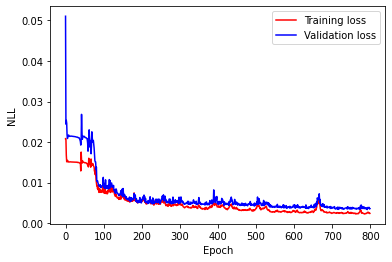

In [44]:
# Track loss
training_loss, validation_loss = [], []

# For each epoch
for i in range(num_epochs):
    
    # Track loss
    epoch_training_loss = 0
    epoch_validation_loss = 0
    
    net.eval()
        
    # For each sentence in validation set
    for _,(inputs, targets) in enumerate(validationloader):
        batch = inputs.shape[0]

        if use_cuda:
          inputs = inputs.float().cuda()
        else:
          inputs = inputs.float()
        targets = targets.float()
        
        # Forward pass
        outputs = net(inputs)

        # Compute loss
        loss = criterion(outputs, targets)
        # Update loss
        epoch_validation_loss += loss.detach().numpy() * batch
    
    net.train()
    
    # For each sentence in training set
    for _,(inputs, targets) in enumerate(trainloader):
        batch = inputs.shape[0]

        if use_cuda:
          inputs = inputs.float().cuda()
        else:
          inputs = inputs.float()

        targets = targets.float()
        # Forward pass
        outputs = net(inputs)
        # Compute loss
        # YOUR CODE HERE!
        loss = criterion(outputs, targets)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Update loss
        epoch_training_loss += loss.detach().numpy() * batch
        
    # Save loss for plot
    training_loss.append(epoch_training_loss/len(training_set))
    validation_loss.append(epoch_validation_loss/len(validation_set))

    # Print loss every 10 epochs
    if i % 10 == 0:
        print(f'Epoch {i}, training loss: {training_loss[-1]}, validation loss: {validation_loss[-1]}')

# Plot training and validation loss
epoch = np.arange(len(training_loss))
plt.figure()
plt.plot(epoch, training_loss, 'r', label='Training loss',)
plt.plot(epoch, validation_loss, 'b', label='Validation loss')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('NLL')
plt.show()

#Implement Test Loop

In [45]:
targets_test = []
outputs_test = []
targets_for_error = []
outputs_for_error = []
test_error = 0
epoch_testing_loss = 0

net.eval()
for _,(inputs, targets) in enumerate(testloader):
  target = []
  output = []
  inputs = inputs.float().cuda()
  targets = targets.float()
  targets_for_error += targets.tolist()
  for i in range(len(targets)):
    target.append(np.round(scaler.inverse_transform(targets[i])))
  targets_test = targets_test + target
  # Forward pass
  # output = np.round(net.forward(inputs).data.numpy())
  outputs = net.forward(inputs).data.numpy()
  outputs_for_error += outputs.tolist()
  for i in range(len(outputs)):
    output.append(np.round(scaler.inverse_transform(outputs[i])))
  outputs_test = outputs_test + output

test_error = series_criterion_error(outputs_for_error, targets_for_error)
print("Test error: " + str(test_error))




Test error: 0.004746061549667502


#Calculate Errors per Link per future Hour

In [46]:
### Calculate errors per link, per future hours
error = [[] for _ in range(num_features)]
for hour in range(look_ahead):
  for link in range(8):
    error[link].append(np.mean(np.square(np.subtract(targets_for_error[:][hour][link], outputs_for_error[:][hour][link]))))

for h in range(8):
  for l in range(8):
    print("Error for "+ "link " +str(l+1) + " for hour " + str(h+1) + ": " + str(error[link][h]))

Error for link 1 for hour 1: 0.0015992448530679796
Error for link 2 for hour 1: 0.0015992448530679796
Error for link 3 for hour 1: 0.0015992448530679796
Error for link 4 for hour 1: 0.0015992448530679796
Error for link 5 for hour 1: 0.0015992448530679796
Error for link 6 for hour 1: 0.0015992448530679796
Error for link 7 for hour 1: 0.0015992448530679796
Error for link 8 for hour 1: 0.0015992448530679796
Error for link 1 for hour 2: 0.006491179349543338
Error for link 2 for hour 2: 0.006491179349543338
Error for link 3 for hour 2: 0.006491179349543338
Error for link 4 for hour 2: 0.006491179349543338
Error for link 5 for hour 2: 0.006491179349543338
Error for link 6 for hour 2: 0.006491179349543338
Error for link 7 for hour 2: 0.006491179349543338
Error for link 8 for hour 2: 0.006491179349543338
Error for link 1 for hour 3: 0.0020312788923866573
Error for link 2 for hour 3: 0.0020312788923866573
Error for link 3 for hour 3: 0.0020312788923866573
Error for link 4 for hour 3: 0.00203127

#Plots for test predictions of 8 hours

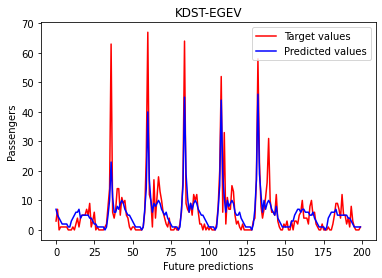

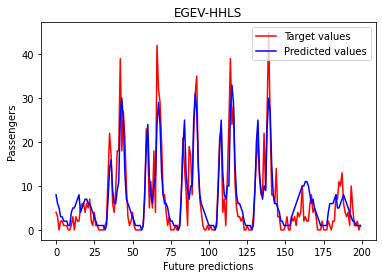

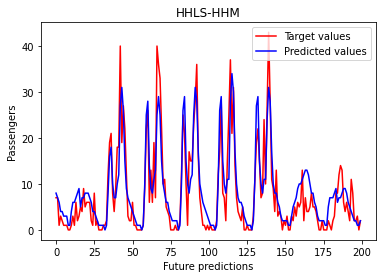

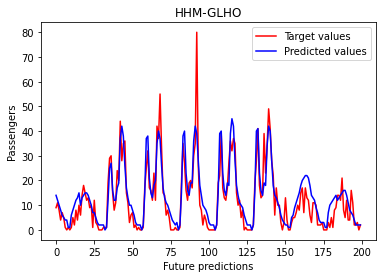

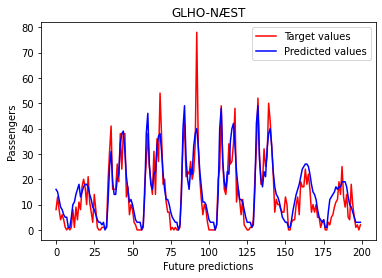

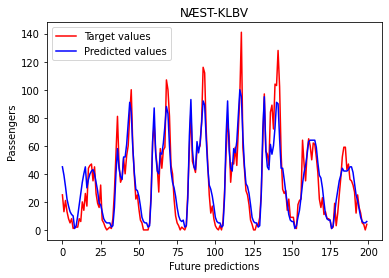

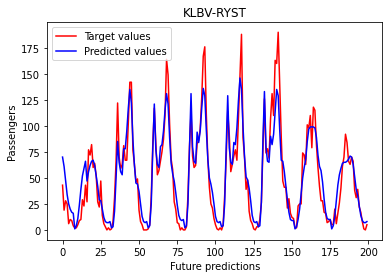

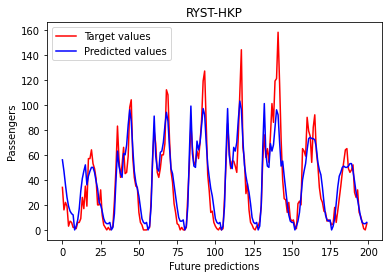

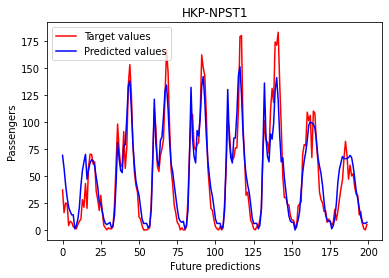

In [47]:
MAX_HOURS = 200
predictions = np.arange(len(targets_test) * len(targets_test[0]))
targetsToShow = [[] for _ in range(num_features)]
outputsToShow = [[] for _ in range(num_features)]

for link in range(num_features):
  for i in range(len(targets_test)):
    for j in range(len(targets_test[0])):
      targetsToShow[link].append(targets_test[i][j][link])
      outputsToShow[link].append(outputs_test[i][j][link])
  plt.figure()
  title = stop_names[link] + '-' + stop_names[link+1]
  plt.plot(predictions[:MAX_HOURS], targetsToShow[link][:MAX_HOURS], 'r', label = 'Target values')
  plt.plot(predictions[:MAX_HOURS], outputsToShow[link][:MAX_HOURS], 'b', label = 'Predicted values')
  plt.legend()
  plt.title(title)
  plt.xlabel('Future predictions'), plt.ylabel('Passengers')
  plt.show()

#Test Naive Forecasting Model- Smoothing Moving Average

200
Test L1 Loss: 0.127
Test L2 Loss: 0.026


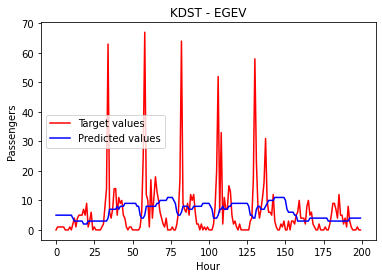

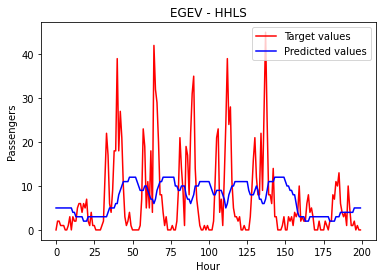

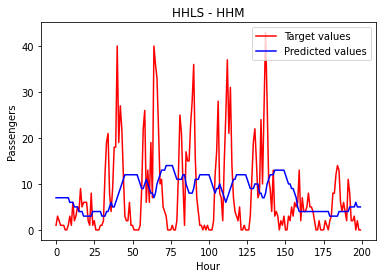

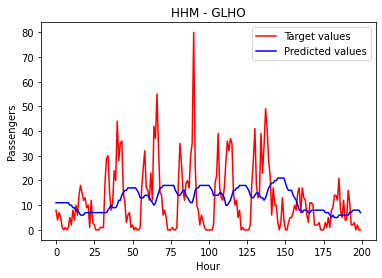

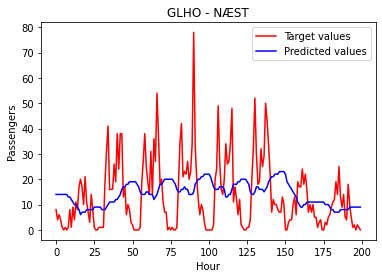

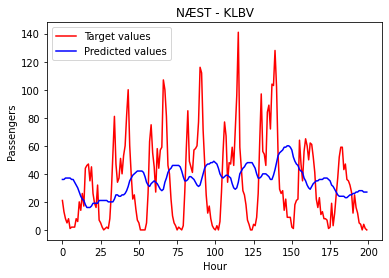

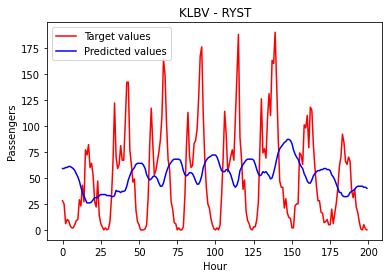

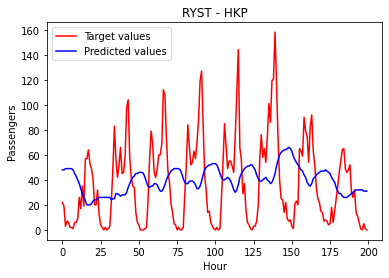

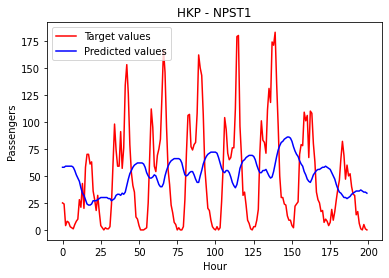

Test L1 Loss: 0.141
Test L2 Loss: 0.032


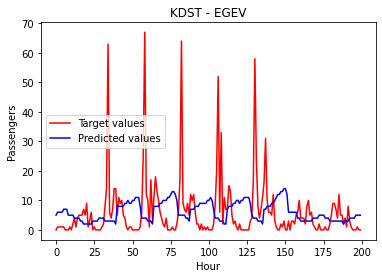

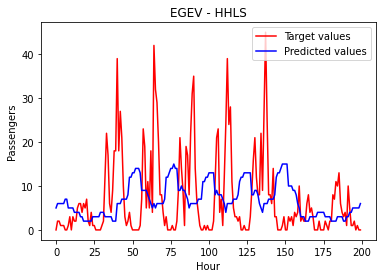

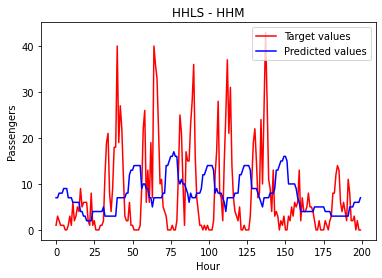

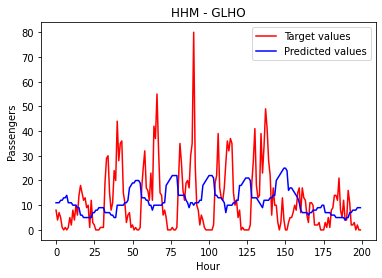

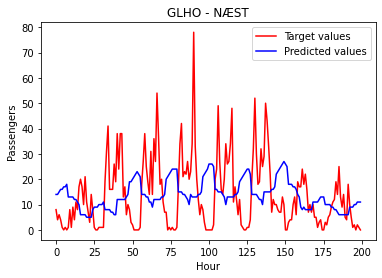

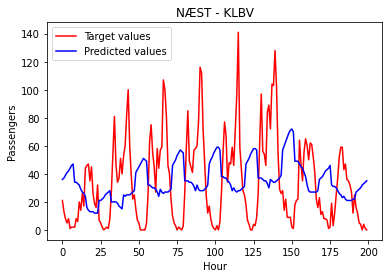

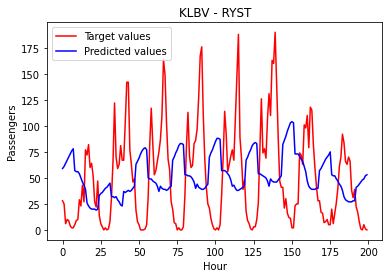

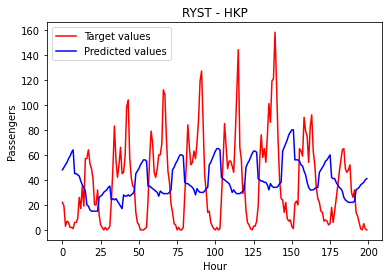

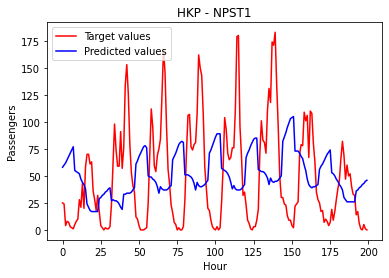

In [48]:
from sklearn.metrics import mean_squared_error
window = look_back
start_naive = start - window
def naive_model(data, start, num_steps, window=20):
    window = window
    history = [data[start+i] for i in range(window)]
    actual = [data[start+i] for i in range(window, num_steps + window)]
    print(str(len(actual)))
    preds = list()

    for t in range(len(actual)):
        length = len(history)
        yhat = np.mean([history[i] for i in range(length-window, length)], axis=0)
        observation = actual[t]
        preds.append(yhat)
        history.append(observation)
    error = mean_squared_error(actual, preds)

    l1_loss_list = list()
    for i in range(len(preds)):
        l1_loss_list.append(abs(preds[i]-actual[i])) 
        
    l1_loss = np.mean(l1_loss_list)

    print('Test L1 Loss: %.3f' % l1_loss )
    print('Test L2 Loss: %.3f' % error )

    actual = np.round(scaler.inverse_transform(actual))
    preds = np.round(scaler.inverse_transform(preds))
    plot_extrapolation(preds, actual)
    

def naive_model_8hr_prediction(data, start, num_steps, window=20, look_ahead=1):
    window = window
    history = [data[start+i] for i in range(window)]
    actual = [data[start+i] for i in range(window, num_steps + window)]
    preds = list()

    for t in range(0, len(actual)):
        length = len(history)
        if not t%look_ahead:
            history[length-window:length] = data[start+(length-window):start+length]
        yhat = np.mean([history[i] for i in range(length-window, length)], axis=0)
        observation = actual[t]
        preds.append(yhat)
        history.append(yhat)
    error = mean_squared_error(actual, preds)

    l1_loss_list = list()
    for i in range(len(preds)):
        l1_loss_list.append(abs(preds[i]-actual[i])) 
        
    l1_loss = np.mean(l1_loss_list)

    print('Test L1 Loss: %.3f' % l1_loss )
    print('Test L2 Loss: %.3f' % error )

    actual = np.round(scaler.inverse_transform(actual))
    preds = np.round(scaler.inverse_transform(preds))
    plot_extrapolation(preds, actual)
    

baseline_pred = naive_model(X, start_naive, num_steps, window)
baseline_pred_8hr = naive_model_8hr_prediction(X, start_naive, num_steps, window, look_ahead=8)